# FJ Model with limited knowledge - Convergence

In [1]:
%matplotlib inline
import numpy as np
from numpy import diag
import numpy.random as rand
from numpy.linalg import norm, inv, eigvals

import sys
from IPython import display
from tqdm import tqdm
from ipyparallel import Client

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain, repeat

import models
from util import *
from viz import *

plt.rcParams['figure.figsize'] = (12.0, 8.0)

/home/user/opinions-research/env/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Norm and Distance from Equilibrium

We will start by testing the hypothesis that the distance from the equilibrium is proportional to the norm of matrix A.

## First experiment - Complete Graph
In this first experiment we begin with a complete graph and change the weights of B to create matrices with different norms. For each of those matrices we run the model 40 times to eliminate possible deviations due to the random nature of the model. At the end, we plot the infinite norm of the distance from the expected equilibrium versus the norm of matrix A.

In [3]:
def adjustNorm(A, multiplier):
    '''
    Set the diagonal elements of A to be equal to the sum of their row
    times the multiplier.
    '''
    np.fill_diagonal(A, 0)
    rowSums = np.sum(A, 0)
    A = A + (diag(rowSums) * multiplier)
    return row_stochastic(A)

In [4]:
# Set simulation parameters
rand.seed(49448)
max_rounds = 10000
N = 10
NETWORK_REPS = 40

# Create 14 identical multipliers for each distinct multiplier value
multipliers = list(chain.from_iterable(repeat(mul, NETWORK_REPS) for mul in np.linspace(1, 1e-5, 20)))
# Create Networks
A = np.ones((N, N))
networks = [adjustNorm(A, mul) for mul in multipliers]
print('Generated {0} networks'.format(len(networks)))

Generated 800 networks


In [5]:
# Initialize ipyparallel
variables = dict(max_rounds=max_rounds, Inf=np.Inf)
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh', variables=variables)

[*] 15 parallel engines available
[*] Finished setting working directories


In [6]:
def run_model(A):
    import models
    return models.meetFriend_matrix_nomem(A, max_rounds, norm_type=Inf)

result = parallel_map(v, run_model, networks)

[*] Running simulation. Do not interrupt this process!


[*] Done!


In [9]:
# Save for later
np.savetxt('random1.txt', result)

In [ ]:
# Open saved data
result = np.loadtxt('random1.txt')

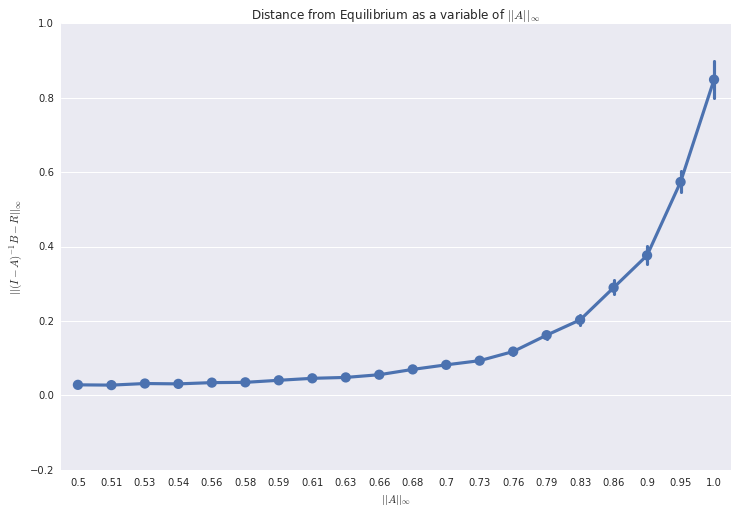

In [12]:
norms = np.array([norm(A-diag(diag(A)), np.Inf) for A in networks])
result = np.array(result)
norms = np.round(norms, decimals=2)
sns.pointplot(norms, result)
plt.xlabel('$||A||_{\infty}$')
plt.ylabel('$||(I-A)^{-1}B - R||_{\infty}$')
plt.title('Distance from Equilibrium as a variable of $||A||_{\infty}$')
plt.show()

# Convergence

- N = 10
- Small norms of A for faster convergence
- Count distance from equilibrium using infinite norm
- Plot Log10 of distance

In [4]:
rand.seed(4002)

N = 10
A = np.ones((N, N))
max_rounds = 1e6
multipliers = np.linspace(0.1, 1.0, 6)
networks = [adjustNorm(A, m) for m in multipliers]
print 'Infinite Norms = '
for network in networks:
    print(norm(network-diag(diag(network)), np.Inf))

Infinite Norms = 
0.909090909091
0.78125
0.684931506849
0.609756097561
0.549450549451
0.5


In [5]:
# Initialize ipyparallel
v, dv = parallel_init('/home/user/opinions-research/', profile='ssh', variables=dict(max_rounds=max_rounds, norm_type=np.Inf))

[*] 15 parallel engines available
[*] Finished setting working directories


In [6]:
def run_model(A):
    import models
    return models.meetFriend_matrix(A, max_rounds, norm_type=norm_type)
    
result = parallel_map(v, run_model, networks)

[*] Running simulation. Do not interrupt this process!


[*] Done!


In [7]:
np.savetxt('randommatrix2.txt', result)

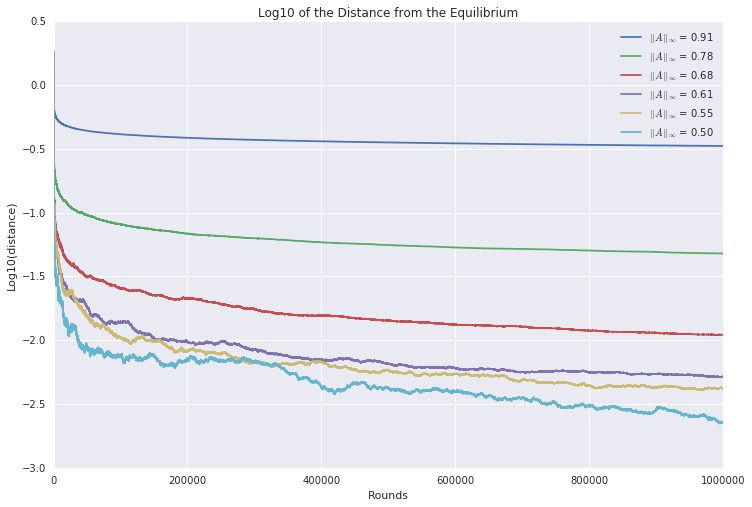

In [9]:
for idx, op in enumerate(result):
    net_norm = '{:.2f}'.format(norm(networks[idx]-diag(diag(networks[idx])), np.Inf))
    plt.plot(np.log10(op), label='$||A||_{\infty}$ = ' + net_norm)
plt.xlabel('Rounds')
plt.ylabel('Log10(distance)')
plt.title('Log10 of the Distance from the Equilibrium')
plt.legend()
plt.show()